# 一、总体思路

本题目分为两个任务，任务一是``客群预测``，为二分类任务；任务二是``转化时点预测``，为时序预测任务，可看作1-14多分类任务。  
此外，本题有一个重要前提是低算力场景，且需要在4天内提交A榜，在3天内提交B榜。  
因此选择树模型作为主要模型，并基于base, trx, view三类数据进行特征构造，并主要解决了任务一。

# 二、数据分析

## 2.1 base

base表中包括字段``cust_wid``,``label``,``age``,``gdr_cd``,``cty_cd``,  
其中``cust_wid``作为索引用于三个表的连接和查询，``age``具有加和性质，可以直接作为连续特征。``gdr_cd``缺失值较多，为无加和性质的离散类别变量，训练集中共有176种，若编码为one-hot，维数过高，不利于树模型训练，故考虑利用Word2Vec进行Embedding

In [11]:
import pandas as pd
info_base = pd.read_csv('/data/train_base.csv')
print(info_base.isna().sum())
print('------------------')
print("cty_cd 类别数:", len(set(info_base['cty_cd'])))
print('------------------')
info_base.describe()


cust_wid        0
label           0
age          2385
gdr_cd       2385
cty_cd      35718
dtype: int64
------------------
cty_cd 类别数: 176
------------------


,label,age
count,100000.000000,97615.000000
mean,2.495940,37.088572
std,3.963317,11.812828
min,0.000000,-1.000000
25%,0.000000,28.000000
50%,0.000000,35.000000
75%,3.000000,43.000000
max,14.000000,98.000000


## 2.2 trx

trx表中包括字段``cust_wid``,``trx_cd``,``trx_amt``,``trx_tm``,  
``trx_cd``猜测为脱敏之后的交易类别，共有42类，可以通过one-hot编码为42维特征，``trx_amt``猜测为脱敏之后的交易金额，为连续变量，考虑与one-hot编码相乘，处理为每个类别的交易金额总数，此外，为了探究交易金额的特征与label的关系，可以选择部分数值特征，如最大值、最小值、平均数、总和等。``trx_tm``为脱敏后的时间戳特征。

In [16]:
import pandas as pd
info_trx = pd.read_csv('/data/train_trx.csv')
print(info_base.isna().sum())
print('------------------')
print("trx_cd 类别数:", len(set(info_trx['trx_cd'])))
print('------------------')
info_trx.describe()

cust_wid       0
trx_cd      6283
trx_amt     6283
trx_tm      6283
dtype: int64
------------------
trx_cd 类别数: 42
------------------


,trx_amt
count,3.094470e+06
mean,-2.318184e+00
std,1.144614e+01
min,-5.077400e+02
25%,-5.520000e+00
50%,-3.100000e+00
75%,-1.440000e+00
max,4.184900e+02


## 2.3 view

trx表中包括字段``cust_wid``,``page_id``,``acs_tm``,  
其中``page_id``猜测为脱敏后的浏览页编号，共有2326种，考虑使用Word2Vec进行Embedding,  
``acs_tm``猜测为脱敏后的时间戳，选取时间戳的时间特征输入模型，如最大值、最小值、分布范围等

In [18]:
import pandas as pd
info_view = pd.read_csv('/data/train_view.csv', encoding='gbk')
print(info_view.isna().sum())
print('------------------')
# print("trx_cd 类别数:", len(set(info_trx['trx_cd'])))
print('------------------')
info_view.describe()

cust_wid       0
page_id     4021
acs_tm      4021
dtype: int64
------------------
------------------


,cust_wid,page_id,acs_tm
count,5113684,5109663,5109663
unique,100000,2326,1874958
top,T00002,4DEAO,1492-08-11 10:01:01
freq,64,438885,24


# 三、特征构造与分析

In [ ]:
参照上述特征构造方式，获得特征173维，通过判断协方差、嵌入法等方法筛选重要特征，发现view中的特征重要性较高，因此作为主要特征输入模型进行训练。

In [4]:
import pandas as pd
infoDf = pd.read_csv('/tasks/10271/process_0505/train_0505.csv')
infoDf.describe()

,label,age,gdr_1,gdr_2,cty_cd_0,cty_cd_1,cty_cd_2,cty_cd_3,cty_cd_4,cty_cd_5,...,page_id_59,page_id_60,page_id_61,page_id_62,page_id_63,time_min,time_max,time_mean,time_median,range
count,100000.000000,97615.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,95979.000000,95979.000000,95979.000000,95979.000000,95979.000000
mean,2.495940,37.088572,0.52814,0.47186,0.165047,-0.784663,0.576949,0.895912,-0.533642,-0.855524,...,-0.593355,-4.099812,-2.303344,-1.620228,-6.278544,6979.251440,42219.064452,24763.912414,24565.777602,35239.813011
std,3.963317,11.812828,0.49921,0.49921,1.244492,0.820813,0.827780,1.680470,2.267535,0.803515,...,4.507938,6.921085,4.489120,6.169262,6.157619,6939.349658,5991.044409,5228.453672,7172.515024,10014.779878
min,0.000000,-1.000000,0.00000,0.00000,-1.024759,-3.816630,-1.914628,-1.939235,-3.157189,-1.771490,...,-25.869705,-36.069439,-28.808897,-28.905058,-32.745579,1440.000000,1467.000000,1466.750000,1449.000000,0.000000
25%,0.000000,28.000000,0.00000,0.00000,-0.857272,-1.168395,-0.002775,0.017293,-3.134089,-1.691261,...,-3.270840,-8.617578,-4.612465,-5.217755,-10.697555,2241.000000,41162.000000,21799.804688,19749.000000,31646.000000
50%,0.000000,35.000000,1.00000,0.00000,-0.004713,-1.048660,-0.002775,0.017293,-0.008572,-1.251279,...,-0.546449,-3.774548,-1.851313,-1.090231,-5.963219,3956.000000,45102.000000,24817.828125,25063.000000,38845.000000
75%,3.000000,43.000000,1.00000,1.00000,-0.004713,0.007718,1.681869,3.085949,-0.008572,0.007063,...,2.040868,0.321011,0.437872,1.821086,-1.508530,9637.000000,45548.000000,27754.593750,28766.250000,42551.000000
max,14.000000,98.000000,1.00000,1.00000,3.151711,0.007718,1.681869,3.085949,3.931566,0.007063,...,28.229456,38.288406,21.303617,31.446636,23.491283,46071.000000,46079.000000,46073.038462,46076.000000,44639.000000


In [5]:
infoDf.corr()

/tmp/ipykernel_128/3930240996.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  infoDf.corr()


,label,age,gdr_1,gdr_2,cty_cd_0,cty_cd_1,cty_cd_2,cty_cd_3,cty_cd_4,cty_cd_5,...,page_id_59,page_id_60,page_id_61,page_id_62,page_id_63,time_min,time_max,time_mean,time_median,range
label,1.000000,0.039255,-0.111349,0.111349,0.042171,-0.012143,-0.040530,-0.042338,0.045572,0.012196,...,-0.112803,-0.154810,0.007360,-0.005118,-0.107552,-0.004163,0.088885,0.104846,0.089856,0.056057
age,0.039255,1.000000,0.024237,-0.024237,0.345583,-0.333703,-0.067046,-0.161205,0.258440,-0.203629,...,-0.119270,-0.074179,0.127547,0.024817,-0.058002,0.042882,-0.004011,0.055883,0.049416,-0.032004
gdr_1,-0.111349,0.024237,1.000000,-1.000000,-0.005179,-0.016148,0.020780,0.018290,-0.013210,-0.021030,...,0.038630,0.082953,-0.028143,0.074538,0.008898,0.055496,-0.050402,-0.017848,-0.018414,-0.068605
gdr_2,0.111349,-0.024237,-1.000000,1.000000,0.005179,0.016148,-0.020780,-0.018290,0.013210,0.021030,...,-0.038630,-0.082953,0.028143,-0.074538,-0.008898,-0.055496,0.050402,0.017848,0.018414,0.068605
cty_cd_0,0.042171,0.345583,-0.005179,0.005179,1.000000,-0.490730,-0.615643,-0.802082,0.935784,-0.013995,...,-0.059664,-0.012557,0.038109,0.014018,-0.046228,-0.030686,0.030391,0.010736,0.011692,0.039443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
time_min,-0.004163,0.042882,0.055496,-0.055496,-0.030686,-0.033226,0.064891,0.060689,-0.049577,-0.058362,...,0.051218,0.079569,0.128331,0.063999,0.184237,1.000000,-0.195418,0.482993,0.343911,-0.809814
time_max,0.088885,-0.004011,-0.050402,0.050402,0.030391,0.009051,-0.040112,-0.042133,0.038617,0.027419,...,-0.084826,-0.157135,-0.109061,-0.038209,-0.221850,-0.195418,1.000000,0.475118,0.347706,0.733628
time_mean,0.104846,0.055883,-0.017848,0.017848,0.010736,-0.030886,0.018154,0.010060,-0.000781,-0.033242,...,-0.048472,-0.080248,0.024754,0.037071,-0.032191,0.482993,0.475118,1.000000,0.894915,-0.050445
time_median,0.089856,0.049416,-0.018414,0.018414,0.011692,-0.026408,0.012253,0.005469,0.002417,-0.026691,...,-0.043187,-0.063229,0.017448,0.035184,-0.028843,0.343911,0.347706,0.894915,1.000000,-0.030295


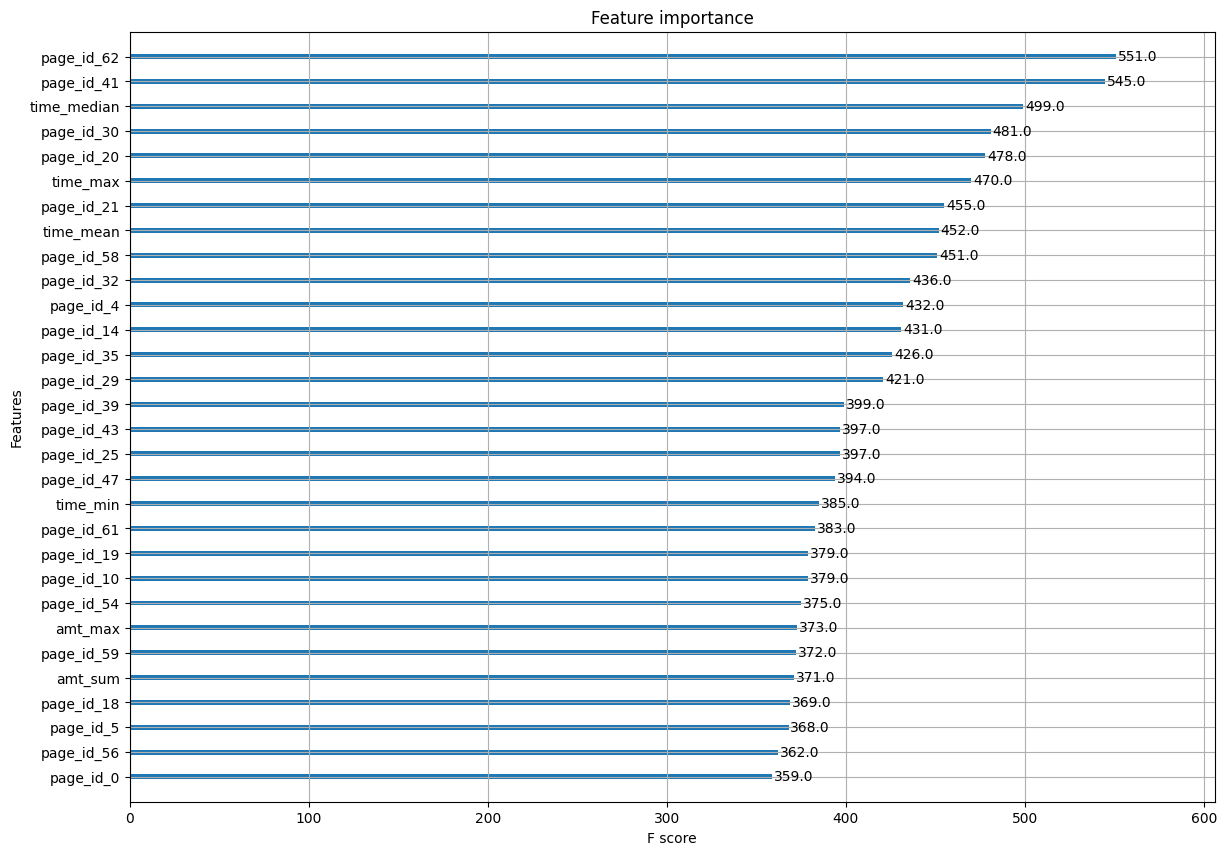

In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt
clf = xgb.Booster()
plt.rcParams["figure.figsize"] = (14, 10)
clf.load_model('/work/reg_stage1_0505/reg_0505.json')
fig = xgb.plot_importance(clf,max_num_features=30)

# 四、模型构建

本课题分为两个任务，采用two-stage的方案完成，  
任务一是二分类任务，因此构建逻辑回归模型，树模型目标设为 ``binary:logistic``, 评价指标为``logloss``  
任务二视为多分类任务，因此构建多分类模型，数模型目标设为 ``multi:softmax``, 评价指标为``mlogloss``


利用RandomizedSearchCV库进行超参数搜索，得到相应的超参数定义如下

In [9]:
# 任务一超参数
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',  # 二分类的问题          
    'gamma': 0.2,                  # 用于控制是否后剪枝的参数,越大越保守。
    'max_depth': 7,               # 构建树的深度，越大越容易过拟合
    'lambda': 3,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 0,                  # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.15,                  # 如同学习率
    'seed': 3407,
    'nthread':16,                  # cpu 线程数
    'eval_metric':'logloss',
}

# 任务二超参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题             
    'num_class':14,                 # 类别数，与 multisoftmax 并用
    'gamma': 0.2,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 7,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 0,                  # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1,                  # 如同学习率
    'seed': 3407,
    'nthread':16,                  # cpu 线程数
    'eval_metric':'mlogloss',
}

实验过程中发现过拟合情况较为严重，线上线下指标差异比较大，因此训练时主要解决过拟合问题，输入数据进行离群点检测删除、训练时采用k折交叉验证，增大L2正则化等方法，实现线上指标的提升。

在推理过程中，也采用two-stage分布进行，先利用模型一进行二分类预测，判断该用户是否会进行资产配置，如若返回正标签，则再利用模型二进行多分类预测。  
值得一提的是，考虑到本课题低算力的要求，因此还尝试只使用模型一返回的logits同时完成两任务。模型一返回的logits的取值范围是[0,1], 因此认为logits更靠近0的用户资产配置欲望更强烈，那么天数也就越少，反之，logits更靠近1的用户资产配置欲望较低，天数较多。对大致分布也进行如下图可视化验证。

<AxesSubplot: ylabel='Density'>

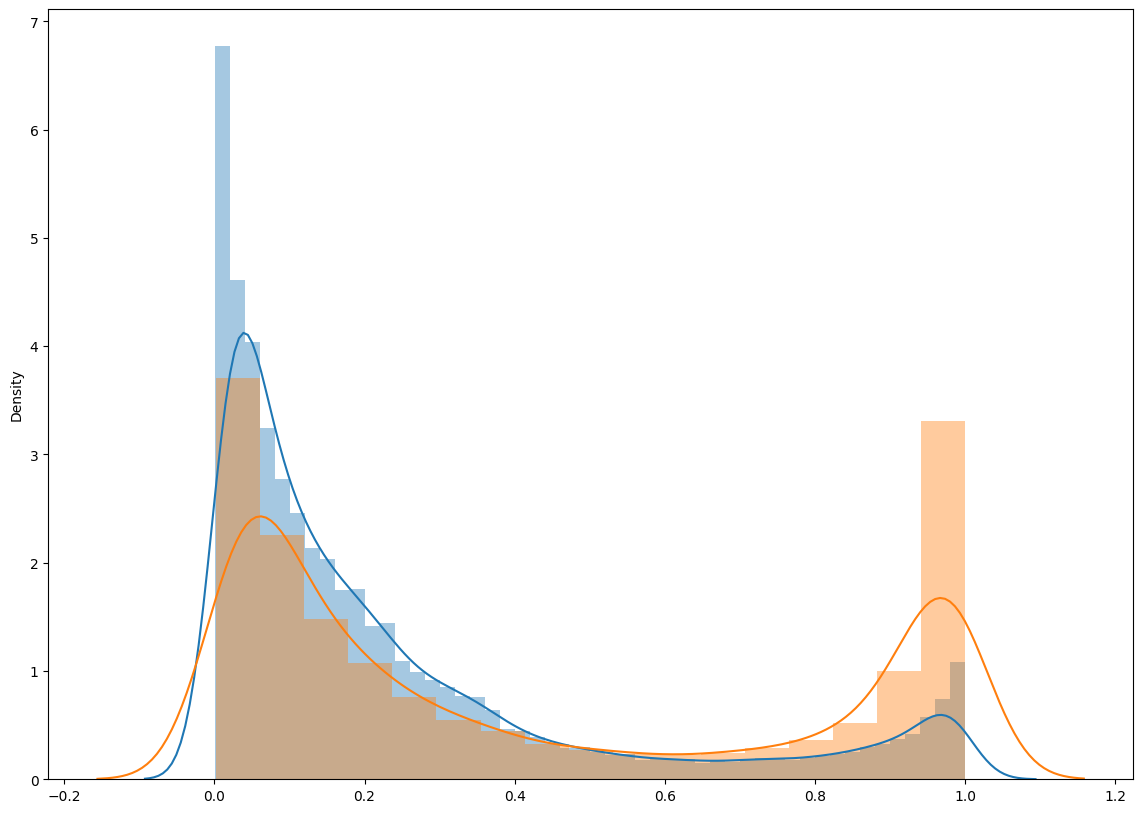

In [13]:
import numpy as np
import warnings 
import seaborn

# testb
warnings.filterwarnings('ignore')
logits = np.load('/work/reg_stage1_0505/logits.txt.npy')
seaborn.distplot(logits, label = 'testb')

# valid
logits_valid = np.loadtxt('/tasks/10766/logits.txt')
seaborn.distplot(logits_valid, label='valid')

# 五、实验结果

A榜: 0.6154969， 任务一F2: 0.7692307692307692，任务二MAPE： 0.7686694551281182  
B榜: 0.57797426, 任务一F2: 0.7285557080785505, 任务二MAPE：0.7529073319928744